In [1]:
import importlib
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

import utility_v1
import propagators_v1
import energy_landscapes_v1

import parallel_simulations_v1
import weighted_ensemble_v1
import metadynamics_v1
import multiple_walker_metadynamics_v1

import visualization_v1

#methods for fast print debugging #<---- these probably belong in utility_v1.py
def p(x):
    print(x)
def pl(x):
    print(len(x))
def ps(x):
    print(x.shape)

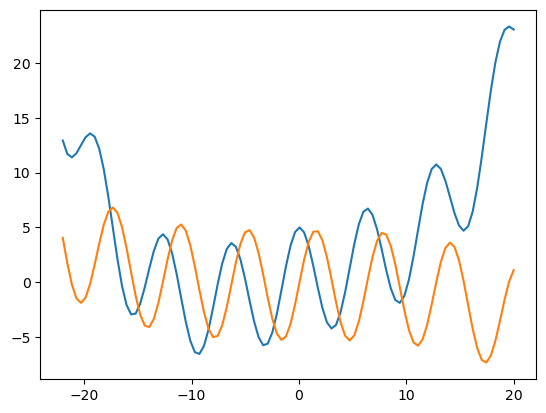

In [183]:
kT = 1
dt = 0.01

importlib.reload(energy_landscapes_v1)

system1 = energy_landscapes_v1.deep_sine_well()
system1.plot_quantity(system1.potential)
system1.plot_quantity(system1.F)
plt.show()



running 150 parallel multiple walker metadynamics simulations for 100000 steps each
molecular time: 100000 steps;  aggregate time: 15000000 steps
data points saved: 30000.0 at 500-step intervals
gaussians of height 0.005 are added every 500 steps
[[-22], [20]]
[202]
bincenters [(-22.105,), (-21.895,), (-21.685,), (-21.475,), (-21.265,), (-21.055,), (-20.845,), (-20.635,), (-20.425,), (-20.215,), (-20.005,), (-19.795,), (-19.585,), (-19.375,), (-19.165,), (-18.955000000000002,), (-18.745,), (-18.535,), (-18.325,), (-18.115000000000002,), (-17.905,), (-17.695,), (-17.485,), (-17.275,), (-17.065,), (-16.855,), (-16.645,), (-16.435000000000002,), (-16.225,), (-16.015,), (-15.805,), (-15.595,), (-15.385000000000002,), (-15.175,), (-14.965,), (-14.755,), (-14.545000000000002,), (-14.335,), (-14.125,), (-13.915000000000001,), (-13.705,), (-13.495000000000001,), (-13.285,), (-13.075000000000001,), (-12.865,), (-12.655000000000001,), (-12.445,), (-12.235000000000001,), (-12.025,), (-11.815000

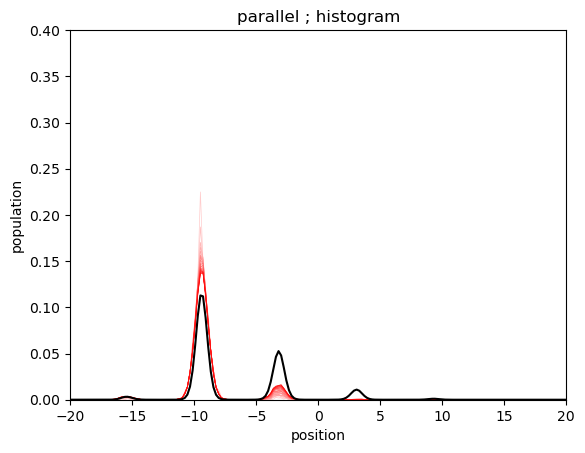

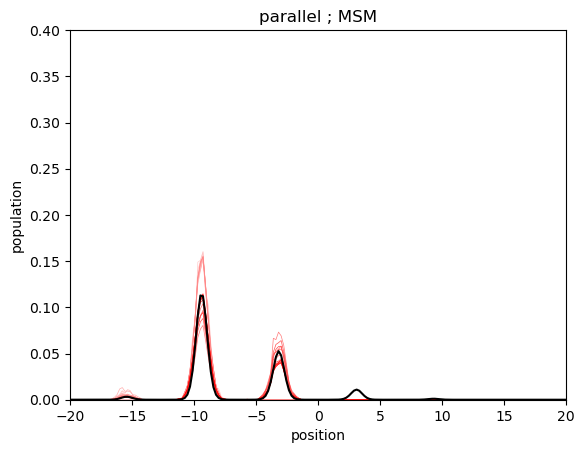

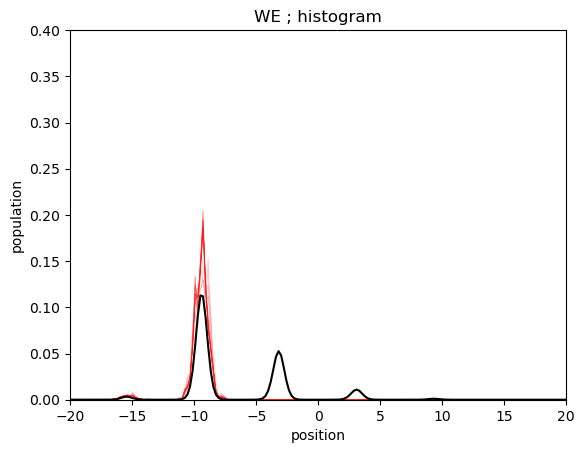

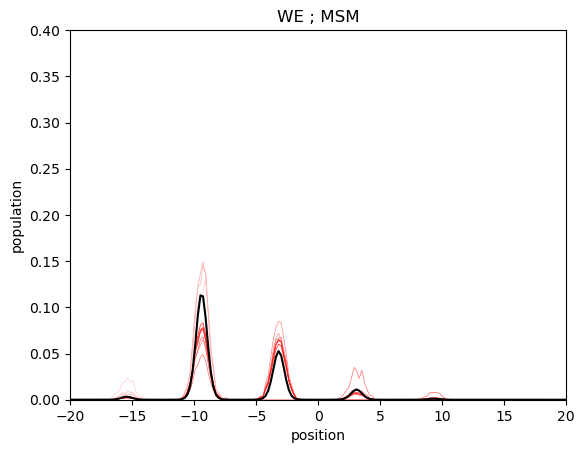

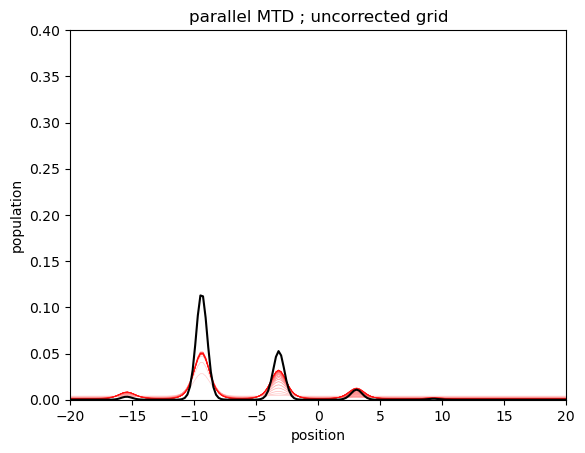

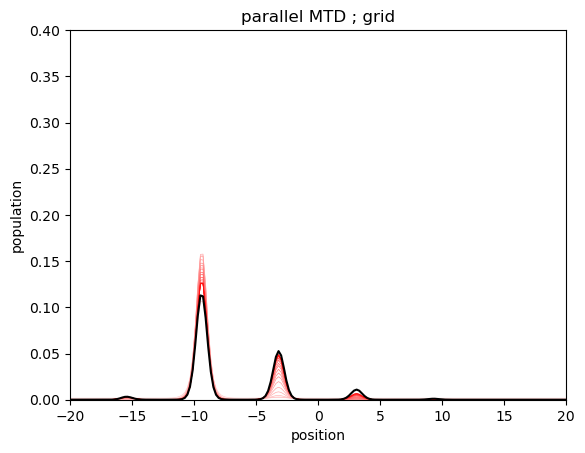

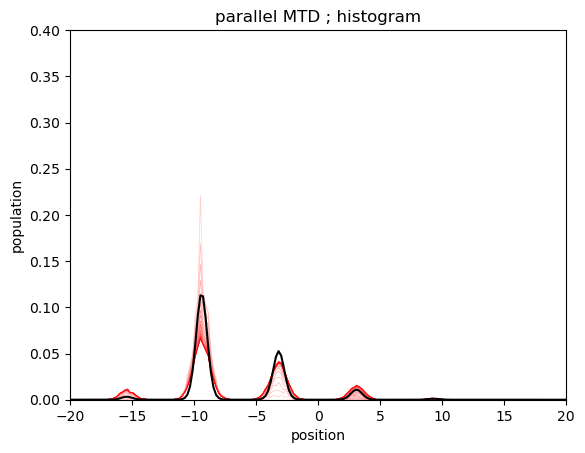

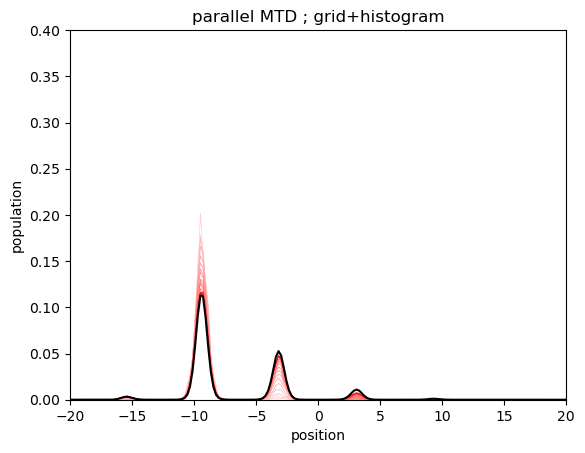

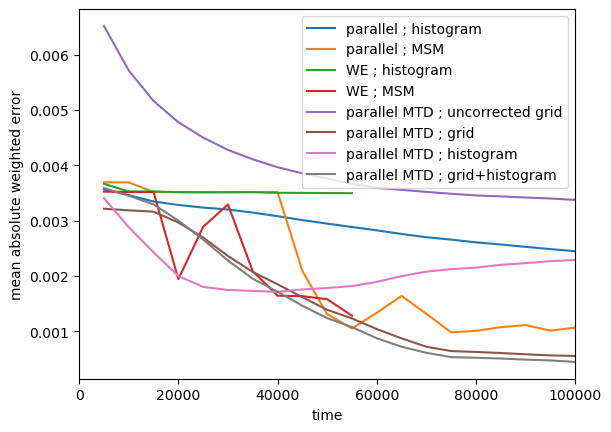

In [184]:
importlib.reload(utility_v1)
importlib.reload(propagators_v1)
importlib.reload(energy_landscapes_v1)

importlib.reload(parallel_simulations_v1)
importlib.reload(weighted_ensemble_v1)
importlib.reload(metadynamics_v1)
importlib.reload(multiple_walker_metadynamics_v1)

importlib.reload(visualization_v1)

#TODO make the parameters below and system (and method hyperparams) into a TEST_SETUP object so we can reproduce ones that worked well
#hyperparameters for estimating convergence
n_timepoints = 20
n_bootstrap = 3

#binning parameters
n_analysis_bins = 200
#save frequency

#simulation time limits (integration steps)
aggregate_simulation_limit = 15000000
#frame_save_limit = 100000
molecular_time_limit = 100000 #20000

#move the number of WE rounds out here; number of data points should be held constant across methods because it reflects lab storage capacity
we_rounds_per_timepoint = 10 #convert to process communication frequency
save_period = int(round(molecular_time_limit/(we_rounds_per_timepoint*n_timepoints))) #in steps

#define bins and calculate the true populations thereof
binbounds, bincenters, step = system1.analysis_bins_1d(n_analysis_bins)
true_populations, true_energies = system1.normalized_pops_energies(kT, bincenters)

#run sampling methods
observables_parallel_mtd = multiple_walker_metadynamics_v1.sampler_parallel_hist_mtd(system1, aggregate_simulation_limit, molecular_time_limit, save_period, n_timepoints, kT, dt, binbounds, bincenters)
observables_parallel = parallel_simulations_v1.sampler_parallel_hist(system1, aggregate_simulation_limit, molecular_time_limit, save_period, n_timepoints, kT, dt, binbounds, bincenters)
observables_we = weighted_ensemble_v1.sampler_we_hist(system1, aggregate_simulation_limit, molecular_time_limit, n_timepoints, we_rounds_per_timepoint, kT, dt, binbounds)

#define which energy landscapes to plot based on the sampling methods and energy landscape estimation methods used
landscape_estimates = [[observables_parallel[0], "parallel ; histogram"], 
                       [observables_parallel[1], "parallel ; MSM"], 
                       [observables_we[0], "WE ; histogram"], 
                       [observables_we[1], "WE ; MSM"],
                       [observables_parallel_mtd[0], "parallel MTD ; uncorrected grid"],
                       [observables_parallel_mtd[1], "parallel MTD ; grid"],
                       [observables_parallel_mtd[2], "parallel MTD ; histogram"],
                       [observables_parallel_mtd[3], "parallel MTD ; grid+histogram"]]
                       


#----------------------------------------------------PLOT RESULTS----------------------------------------------------

landscape_estimates_plot = landscape_estimates

#landscape estimates
for le in landscape_estimates_plot:
    visualization_v1.plot_landscape_estimate(bincenters, le[0], true_populations, le[1], xrange = (-20,20), yrange = (0,0.4))


#convergence over time (separate loop for plotting)
for le in landscape_estimates_plot:

    mean_absolute_error = [np.mean([abs(epi-pi) for pi, epi in zip(true_populations, est_pops)]) for est_pops in le[0]]
    times = [int(round((t+1)*(molecular_time_limit/n_timepoints))) for t in range(len(mean_absolute_error))]
    
    plt.plot(times, mean_absolute_error)

plt.legend([le[1] for le in landscape_estimates_plot])
plt.xlabel("time")
plt.ylabel("mean absolute weighted error")

plt.xlim(0,molecular_time_limit)
#plt.ylim(0,0.1)

plt.show()


In [ ]:

#---------------------------------------------------------------------------------------------------------------------------

# #bin boundaries along each dimension
# binbounds = [np.linspace(system1.standard_analysis_range[0][0], system1.standard_analysis_range[1][0], 14+1),
#              np.linspace(system1.standard_analysis_range[0][1], system1.standard_analysis_range[1][1], 6+1)]

# #get true populations
# state_bins = msm_trj_analysis.bin_to_voxels_msmstates(binbounds, system1.x)
# state_pops = msm_trj_analysis.state_to_bin_populations(state_bins, system1.p)

# #run sampler
# est_state_pop_convergence_we, maew_convergence_we = weighted_ensemble_4.sampler_we_hist(system1, int(nsteps/10), n_timepoints, kT, dt, binbounds)
# est_state_pop_convergence_parallel, maew_convergence_parallel = msm_trj_long_simulation.sampler_parallel_hist(system1, n_parallel, nsteps, save_period, n_timepoints, kT, dt, binbounds)

# #plot results
# for espc in est_state_pop_convergence_parallel:
#     plt.plot(espc)

# plt.plot(state_pops, color="black")
# plt.show()

# #plot results
# for espc in est_state_pop_convergence_we:
#     plt.plot(espc)

# plt.plot(state_pops, color="black")
# plt.show()

# plt.plot(maew_convergence_parallel)
# plt.plot(maew_convergence_we)
# plt.show()